# Support Vector Machine

Author: Luke Moraglia

This notebook gives an overview of support vector machines for classification.
It implements a `SVC` from `scikit-learn`.

## Main idea
Support vector machines are a group of binary classification algorithms, whose main idea is to split the space of the observations using a hyperplane. This separating hyperplane has one fewer dimension than the space of predictors that it splits. For instance a space with two predictors would have a hyperplane that is a one-dimensional line, while a space with three predictors would have a hyperplane that is a two-dimensional plane. I personally always picture the three predictor case, where the three-dimensional space is divided in half by a flat 2D plane, though you might also find it nice to picture the 2 predictor case. To start, it's easiest to picture the hyperplane as a straight line or plane, and this corresponds to the linear case of SVM, but as we will see, the linear case is not the only one that we are confined to.
Support vector machines attempt to find the hyperplane that best separates the two classes onto separate sides of the hyperplane.

## Maximum margin and soft margin
If the training observations can be perfectly separated by the hyperplane, the hyperplane could be chosen to maximize the margin, the distance between the hyperplane and the nearest observation to the hyperplane. In general, the training data are often not perfectly separable and this may not be the best hyperplane anyway when using cross validation to test new observations. Instead, the algorithm can use a soft margin which allows for some training observations to be on the wrong side of the margin, or even misclassified (on the "wrong" side of the hyperplane). A tuning hyperparameter, $C$, controls the number of violations that we are willing to accept, with higher $C$ resulting in a softer margin.

## Regularization in linear and logistic regression
In linear and logistic regression, regularization can help prevent overfitting by increasing bias and lowering variance. In these methods, regularization amounts to shrinking the coefficients in the regression by applying a penalty to the minimization. In ridge (L2) regression, this penalty constrains the sum of the *squared* coefficients multiplied by a tuning parameter $\lambda$ such that a smaller sum of squared coefficients is preferred. The tuning parameter $\lambda$ can be increased or decreased to control the amount of regularization.

Similar to ridge regression, the Lasso uses a penalty that constrains the sum of the *absolute values* of the coefficients, again multiplied by $\lambda$. This has a similar effect as ridge regression, but includes the added feature that some coefficients can become exactly zero rather than just close to zero. Finally, elastic net regularization is a hybrid between ridge regression and the Lasso that includes both penalties, each with their own tuning parameter so that the amount of regularization can be tuned for each type of penalty.

## Back to SVM: regularizing and kernels
Why am I telling you all this about linear and logistic regression regularization? In SVM, we also have a tuning parameter that affects the bias-variance tradeoff: $C$! For SVM, larger $C$ is very similar to a larger $\lambda$ in ridge regression.

To this point, I've been mostly thinking of linear hyperplanes for my classifiers. But what if there is a non-linear boundary between the two classes? Perhaps they would be more easily separable by a quadratic hyperplane for instance. We could enlarge the number of predictors to also include these predictors squared, which would have the effect of allowing us to find a quadratic hyperplane. In a similar way, we could use any higher-order polynomial or another transformation entirely to change the hyperplanes that we can use to separate the observations. This transformation amounts to changing the *kernel* of the SVM. I won't go into the math here, as even a great resource like *ISLR* does not fully explain it. The linear classifier that I first describe corresponds to the "linear" kernel and the higher-order polynomials to the "polynomial" kernel. Another widely used kernel is the radial basis function (RBF). The RBF gives the most importance to an observation's nearby points when classifying it, so far away points have very little influence on the classification.

## Citations / Resources

- [Occupancy Dataset](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#): Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, Véronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.
- [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine)
- [Statquest](https://youtube.com/playlist?list=PLblh5JKOoLUL3IJ4-yor0HzkqDQ3JmJkc)
- [sklearn](https://scikit-learn.org/stable/modules/svm.html#svm-classification)
- [ISLR](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf) ch 9, pg 367

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt
import seaborn as sns

from helpers import cust_func

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use("fivethirtyeight")
%load_ext autoreload
%autoreload 2

In [2]:
data_train = pd.read_csv("data/occupancy_data/datatraining.txt")
data_test = pd.read_csv("data/occupancy_data/datatest.txt")
data_all = pd.concat([data_train, data_test], ignore_index=True)

In [3]:
data_all

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.180000,27.272000,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.150000,27.267500,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.150000,27.245000,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.150000,27.200000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.100000,27.200000,426.0,704.50,0.004757,1
...,...,...,...,...,...,...,...
10803,2015-02-04 10:38:59,24.290000,25.700000,808.0,1150.25,0.004829,1
10804,2015-02-04 10:40:00,24.330000,25.736000,809.8,1129.20,0.004848,1
10805,2015-02-04 10:40:59,24.330000,25.700000,817.0,1125.80,0.004841,1
10806,2015-02-04 10:41:59,24.356667,25.700000,813.0,1123.00,0.004849,1


In [4]:
data_all.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,10808.000000,10808.000000,10808.000000,10808.00000,10808.000000,10808.000000
mean,20.819992,25.638407,137.694088,634.00507,0.003903,0.249907
std,1.078410,4.953792,212.175483,312.81727,0.000803,0.432979
min,19.000000,16.745000,0.000000,412.75000,0.002674,0.000000
25%,20.000000,21.390000,0.000000,441.00000,0.003323,0.000000
50%,20.700000,25.680000,0.000000,464.00000,0.003805,0.000000
75%,21.500000,28.324167,413.541667,761.00000,0.004372,0.000000
max,24.408333,39.117500,1697.250000,2028.50000,0.006476,1.000000


In [5]:
X_train = data_train.drop(["Occupancy", "date"], axis = 1).copy()
X_test = data_test.drop(["Occupancy", "date"], axis = 1).copy()
X_all = data_all.drop(["Occupancy", "date"], axis = 1).copy()

In [6]:
X_all

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.180000,27.272000,426.0,721.25,0.004793
1,23.150000,27.267500,429.5,714.00,0.004783
2,23.150000,27.245000,426.0,713.50,0.004779
3,23.150000,27.200000,426.0,708.25,0.004772
4,23.100000,27.200000,426.0,704.50,0.004757
...,...,...,...,...,...
10803,24.290000,25.700000,808.0,1150.25,0.004829
10804,24.330000,25.736000,809.8,1129.20,0.004848
10805,24.330000,25.700000,817.0,1125.80,0.004841
10806,24.356667,25.700000,813.0,1123.00,0.004849


In [7]:
y_train = data_train["Occupancy"]
y_test = data_test["Occupancy"]
y_all = data_all["Occupancy"]

In [8]:
y_all

0        1
1        1
2        1
3        1
4        1
        ..
10803    1
10804    1
10805    1
10806    1
10807    1
Name: Occupancy, Length: 10808, dtype: int64

## Target Distribution

<AxesSubplot:xlabel='Occupancy', ylabel='Count'>

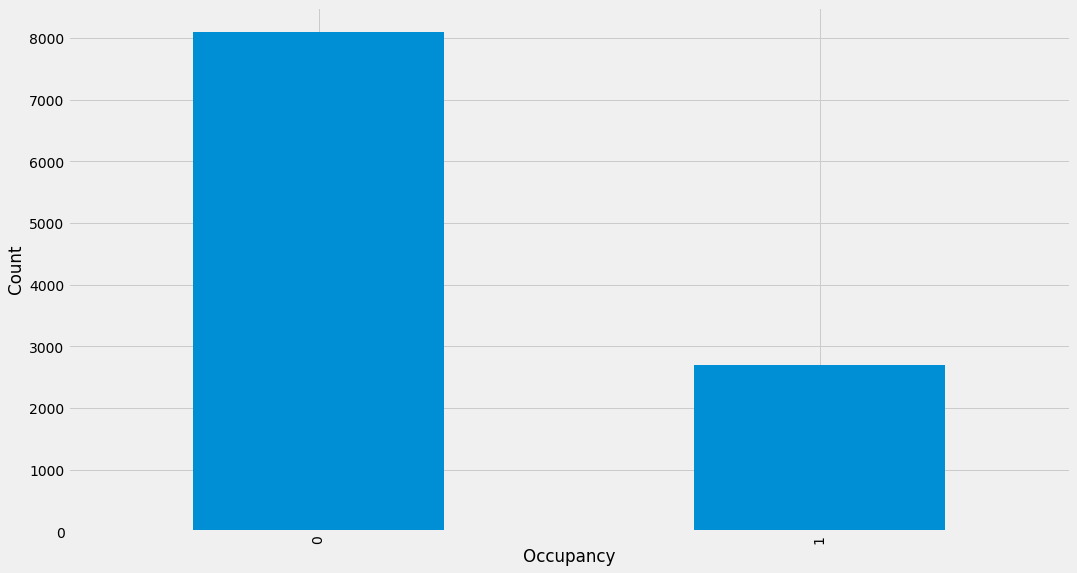

In [9]:
y_all.groupby(y_all).count().plot.bar(ylabel='Count')

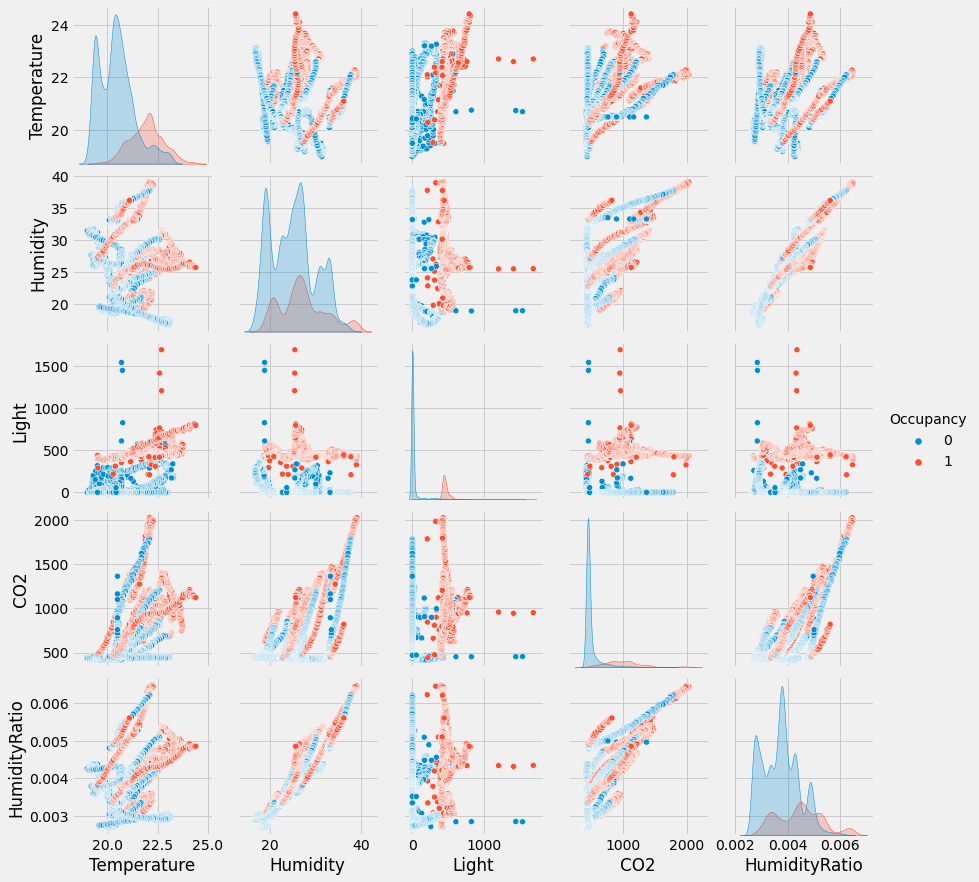

In [10]:
sns.pairplot(data_all, hue='Occupancy')

## Scale and SVC baseline pipeline

In [11]:
# create pipeline with a scaler 
steps = [('scaler', StandardScaler()), ('rbf_svm', SVC())]
baseline_pipe = Pipeline(steps)

In [12]:
baseline_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rbf_svm', SVC())])

In [13]:
train_score = baseline_pipe.score(X_train, y_train)
test_score = baseline_pipe.score(X_test, y_test)
print(f"Train Score: {round(train_score, 3)}")
print(f"Test Score: {round(test_score, 3)}")

Train Score: 0.989
Test Score: 0.97


Red flags going off in my head!

In [14]:
cm = cust_func.nice_conf_mat(y_test,
                         baseline_pipe.predict(X_test))

,Predicted Negative,Predicted Positive
True Negative,1616,77
True Positive,3,969


## Randomized Search CV

In [26]:
%%time
# https://stackoverflow.com/questions/28178763/sklearn-use-pipeline-in-a-randomizedsearchcv

param_dist = {
          'rbf_svm__C': loguniform(1e-1, 1e3), 
          'rbf_svm__gamma': loguniform(1e-4, 1e-2)
}

steps = [('scaler', StandardScaler()), ('rbf_svm', SVC())]
search_pipe = Pipeline(steps)

# do search
search = RandomizedSearchCV(search_pipe,
                            param_distributions=param_dist,
                            n_iter=50,
                            verbose=2,
                            random_state=42)
# Uncomment to run RandomizedSearchCV. Takes a while. 
# search.fit(X_train, y_train)
# search_pipe = search.best_estimator_
# search.best_params_

CPU times: total: 0 ns
Wall time: 1 ms


In [22]:
steps = [('scaler', StandardScaler()), ('rbf_svm', SVC(C=206.51425578959243,
                                                       gamma=0.000517019178636699))]
search_pipe = Pipeline(steps)
search_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rbf_svm',
                 SVC(C=206.51425578959243, gamma=0.000517019178636699))])

In [23]:
search_pipe.named_steps

{'scaler': StandardScaler(),
 'rbf_svm': SVC(C=206.51425578959243, gamma=0.000517019178636699)}

In [24]:
train_score = search_pipe.score(X_train, y_train)
test_score = search_pipe.score(X_test, y_test)
print(f"Train Score: {round(train_score, 3)}")
print(f"Test Score: {round(test_score, 3)}")

Train Score: 0.986
Test Score: 0.979


Red flags going off in my head, still!

In [25]:
cm = cust_func.nice_conf_mat(y_test,
                         search_pipe.predict(X_test))

,Predicted Negative,Predicted Positive
True Negative,1639,54
True Positive,2,970


A little bit improved classification